In [5]:
from scipy.linalg import eigvals
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import time
from scipy.ndimage import label
import sympy as sp
from itertools import product
from typing import List, Dict, Tuple
from scipy.optimize import differential_evolution, dual_annealing
from deap import base, creator, tools, algorithms
from pyswarm import pso
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

In [6]:
def sgd_with_bound(f, grad_f, start_point, end_point,learning_rate=0.01, iterations=1000, tol=1e-6):
    x = np.array(start_point, dtype=float)
    x_end = np.array(end_point, dtype=float)
    processed_points = [x]
    for i in range(iterations):
        gradient = grad_f(x)
        x_new = x - learning_rate * gradient
        if all(x_new>=x_end):
            break
        else:
          if np.linalg.norm(x_new - x) < tol:
              break
          x = x_new
          processed_points.append(x)
    return x, f(x),processed_points

def sgd_direct(f, grad_f, start_point, end_point,learning_rate=0.01, iterations=1000, tol=1e-6):
    x = np.array(start_point, dtype=float)
    x_end = np.array(end_point, dtype=float)
    processed_points = [x]
    for i in range(iterations):
        gradient = grad_f(x)
        x_new = x - learning_rate * gradient
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        processed_points.append(x)
    return x, f(x),processed_points

def de_search(f, bounds):
    """Perform Differential Evolution to find a global minimum."""
    result = differential_evolution(f, bounds)
    return result.x, result.fun

def de_search_para(f, bounds,maxiters = 1000):
    """Perform Differential Evolution to find a global minimum."""
    result = differential_evolution(f, bounds,maxiter = maxiters)
    return result.x, result.fun


def generate_combinations(ranges, min_unit=1):
    """
    Generate all combinations within the specified ranges with a given step size.

    Parameters:
    - ranges: List of tuples, where each tuple represents (min, max) for a dimension.

    - min_unit: Step size for each dimension.

    Returns:
    - List of tuples representing all possible combinations.
    """
    # Create a list of lists, where each sublist contains all possible values for that dimension
    value_lists = []
    for dim, (min_val, max_val) in enumerate(ranges):
        if min_unit <= 0:
            raise ValueError("min_unit must be a positive number.")
        # Use range for integer steps or a list comprehension for float steps
        if isinstance(min_val, int) and isinstance(max_val, int):
            values = list(range(min_val, max_val + 1, min_unit))
        else:
            num_steps = int((max_val - min_val) / min_unit) + 1
            values = [min_val + i * min_unit for i in range(num_steps)]
            # Ensure that the last value does not exceed max_val due to floating point arithmetic
            values = [v for v in values if v <= max_val]
        value_lists.append(values)

    # Use itertools.product to compute the Cartesian product of all dimensions
    combinations = list(product(*value_lists))
    return combinations

def global_search(f,bounds,mini_point_unit = 1):
  vals = generate_combinations(bounds,mini_point_unit)
  f_vals = [f(x) for x in vals]
  return np.min(f_vals),vals[np.argmin(f_vals)]

# Simulated Annealing Search
def sa_search(f, bounds):
    """Perform Simulated Annealing to find a global minimum."""
    result = dual_annealing(f, bounds)
    return result.x, result.fun

# Genetic Algorithm Search using DEAP
def ga_search(f, bounds, population_size=50, generations=100, cx_prob=0.7, mut_prob=0.2):
    """Perform Genetic Algorithm to find a global minimum."""
    # Define the problem as a minimization
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Initialize the toolbox
    toolbox = base.Toolbox()
    # Attribute generator
    for i, (low, up) in enumerate(bounds):
        toolbox.register(f"attr_float_{i}", np.random.uniform, low, up)
    # Structure initializers
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     [toolbox.__getattribute__(f"attr_float_{i}") for i in range(len(bounds))], n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Define the evaluation function
    def eval_func(individual):
        return (f(individual),)

    toolbox.register("evaluate", eval_func)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)

    # Statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # Run Genetic Algorithm
    algorithms.eaSimple(population, toolbox, cx_prob, mut_prob, generations, stats=stats, halloffame=hof, verbose=False)

    best_ind = hof[0]
    return best_ind, f(best_ind)

# Particle Swarm Optimization Search using pyswarm
def pso_search(f, bounds):
    """Perform Particle Swarm Optimization to find a global minimum."""
    # Define lower and upper bounds for each dimension
    lb = [b[0] for b in bounds]
    ub = [b[1] for b in bounds]
    xopt, fopt = pso(f, lb, ub)
    return xopt, fopt

In [ ]:
# Define the non-convex function
def f(x):
    """Objective function: f(x, y) = x^4 + y^4 - 4x^2 - 4y^2"""
    return x[0]**4 + x[1]**4 - 4*x[0]**2 - 4*x[1]**2

# Define the gradient of the function
def grad_f(x):
    """Gradient of f."""
    df_dx = 4*x[0]**3 - 8*x[0]
    df_dy = 4*x[1]**3 - 8*x[1]
    return np.array([df_dx, df_dy])

In [ ]:
ns_time_start = time.time()
gs_result = global_search(f,([-3.0,3.0],[-3.0,3.0]),0.1)
ns_time_end = time.time() - ns_time_start

dif_time_start = time.time()
de_result = de_search(f, ([-3.0,3.0],[-3.0,3.0]))
dif_time_end = time.time() - dif_time_start

In [ ]:
gs_result

(-7.996800000000001, (1.4000000000000004, 1.4000000000000004))

In [ ]:
! pip install numpy scipy deap pyswarm


In [ ]:
if __name__ == "__main__":
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Define the bounds for each dimension
    bounds = [(-3.0, 3.0), (-3.0, 3.0)]

    # Store results for plotting
    results = {}

    # Grid-based Global Search
    print("Starting Grid-based Global Search...")
    ns_time_start = time.time()
    gs_min, gs_point = global_search(f, bounds, mini_point_unit=0.1)
    ns_time_end = time.time() - ns_time_start
    print(f"Global Search Result: Minimum Value = {gs_min} at Point = {gs_point}")
    print(f"Time Taken: {ns_time_end:.4f} seconds\n")
    results['Global Search'] = {'point': gs_point, 'value': gs_min, 'time': ns_time_end}

    # Differential Evolution Search
    print("Starting Differential Evolution Search...")
    dif_time_start = time.time()
    de_point, de_min = de_search(f, bounds)
    dif_time_end = time.time() - dif_time_start
    print(f"Differential Evolution Result: Minimum Value = {de_min} at Point = {de_point}")
    print(f"Time Taken: {dif_time_end:.4f} seconds\n")
    results['Differential Evolution'] = {'point': de_point, 'value': de_min, 'time': dif_time_end}

    # Simulated Annealing Search
    print("Starting Simulated Annealing Search...")
    sa_time_start = time.time()
    sa_point, sa_min = sa_search(f, bounds)
    sa_time_end = time.time() - sa_time_start
    print(f"Simulated Annealing Result: Minimum Value = {sa_min} at Point = {sa_point}")
    print(f"Time Taken: {sa_time_end:.4f} seconds\n")
    results['Simulated Annealing'] = {'point': sa_point, 'value': sa_min, 'time': sa_time_end}

    # Genetic Algorithm Search
    print("Starting Genetic Algorithm Search...")
    ga_time_start = time.time()
    ga_point, ga_min = ga_search(f, bounds)
    ga_time_end = time.time() - ga_time_start
    print(f"Genetic Algorithm Result: Minimum Value = {ga_min} at Point = {ga_point}")
    print(f"Time Taken: {ga_time_end:.4f} seconds\n")
    results['Genetic Algorithm'] = {'point': ga_point, 'value': ga_min, 'time': ga_time_end}

    # Particle Swarm Optimization Search
    print("Starting Particle Swarm Optimization Search...")
    pso_time_start = time.time()
    pso_point, pso_min = pso_search(f, bounds)
    pso_time_end = time.time() - pso_time_start
    print(f"Particle Swarm Optimization Result: Minimum Value = {pso_min} at Point = {pso_point}")
    print(f"Time Taken: {pso_time_end:.4f} seconds\n")
    results['Particle Swarm Optimization'] = {'point': pso_point, 'value': pso_min, 'time': pso_time_end}

Starting Grid-based Global Search...
Global Search Result: Minimum Value = -7.996800000000001 at Point = (1.4000000000000004, 1.4000000000000004)
Time Taken: 0.0037 seconds

Starting Differential Evolution Search...
Differential Evolution Result: Minimum Value = -7.999999999999998 at Point = [-1.41421357 -1.41421357]
Time Taken: 0.0361 seconds

Starting Simulated Annealing Search...
Simulated Annealing Result: Minimum Value = -7.999999999999933 at Point = [-1.41421354  1.41421365]
Time Taken: 0.2780 seconds

Starting Genetic Algorithm Search...
Genetic Algorithm Result: Minimum Value = -7.999999999596407 at Point = [1.4142135616529248, -1.414220665123234]
Time Taken: 0.3382 seconds

Starting Particle Swarm Optimization Search...
Stopping search: Swarm best objective change less than 1e-08
Particle Swarm Optimization Result: Minimum Value = -7.999999967788844 at Point = [1.41415237 1.41423034]
Time Taken: 0.1116 seconds



In [ ]:
results

{'Global Search': {'point': (1.4000000000000004, 1.4000000000000004),
  'value': -7.996800000000001,
  'time': 0.0036802291870117188},
 'Differential Evolution': {'point': array([-1.41421357, -1.41421357]),
  'value': -7.999999999999998,
  'time': 0.0360565185546875},
 'Simulated Annealing': {'point': array([-1.41421354,  1.41421365]),
  'value': -7.999999999999933,
  'time': 0.27801966667175293},
 'Genetic Algorithm': {'point': [1.4142135616529248, -1.414220665123234],
  'value': -7.999999999596407,
  'time': 0.3382127285003662},
 'Particle Swarm Optimization': {'point': array([1.41415237, 1.41423034]),
  'value': -7.999999967788844,
  'time': 0.1115560531616211}}

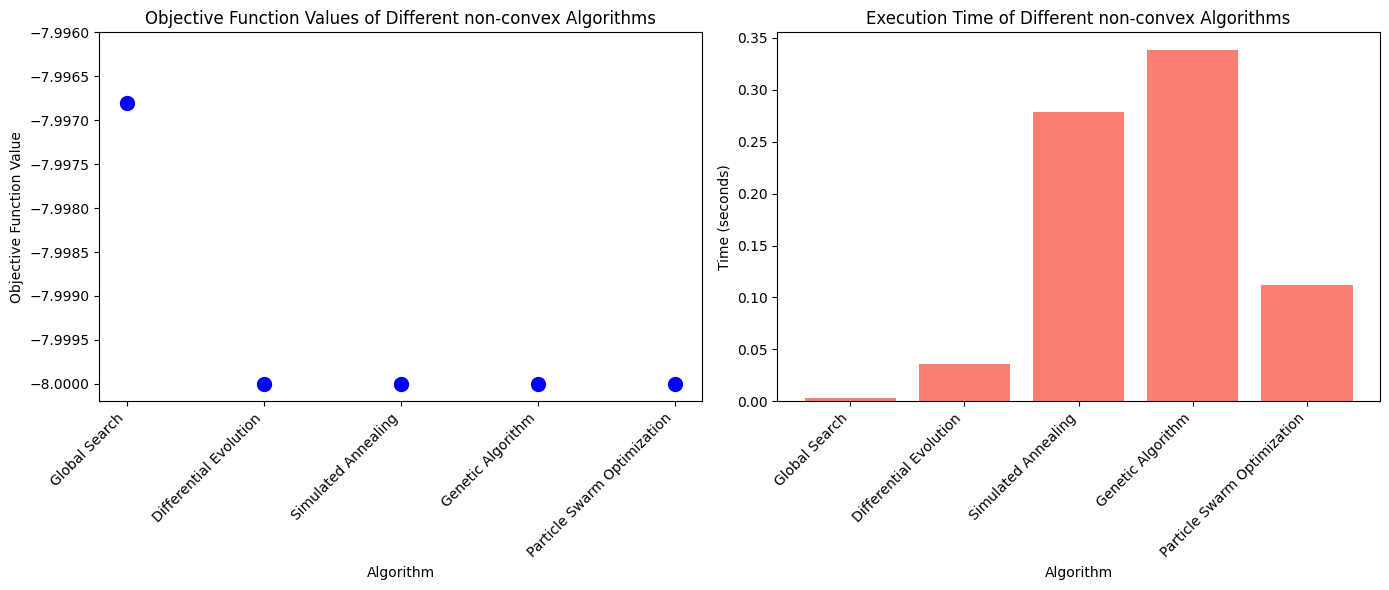

In [ ]:
labels = list(results.keys())
values = [res['value'] for res in results.values()]
times = [res['time'] for res in results.values()]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for values with a zoomed-in y-axis
ax[0].scatter(labels, values, color='blue', s=100)
ax[0].set_xlabel('Algorithm')
ax[0].set_ylabel('Objective Function Value')
ax[0].set_title('Objective Function Values of Different non-convex Algorithms')
ax[0].set_xticks(range(len(labels)))
ax[0].set_xticklabels(labels, rotation=45, ha='right')
ax[0].set_ylim(-8.0002, -7.996)  # Zoomed-in y-axis

# Bar plot for times
ax[1].bar(labels, times, color='salmon')
ax[1].set_xlabel('Algorithm')
ax[1].set_ylabel('Time (seconds)')
ax[1].set_title('Execution Time of Different non-convex Algorithms')
ax[1].set_xticks(range(len(labels)))
ax[1].set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.savefig("comp_non_conv_algo.png", format="png", dpi=300)

plt.show()


Global Search Result: Minimum Value = -6.0 at Point = (-1.0, -1.0)
Time Taken: 0.0005 seconds

Global Search Result: Minimum Value = -7.381095759154761 at Point = (-1.201547249043177, -1.201547249043177)
Time Taken: 0.0004 seconds

Global Search Result: Minimum Value = -7.84638328986338 at Point = (1.3125763965655528, 1.3125763965655528)
Time Taken: 0.0008 seconds

Global Search Result: Minimum Value = -7.8980713191902545 at Point = (-1.4918957169776812, -1.4918957169776812)
Time Taken: 0.0018 seconds

Global Search Result: Minimum Value = -7.991712759977526 at Point = (1.3912688610506052, 1.3912688610506052)
Time Taken: 0.0049 seconds

Global Search Result: Minimum Value = -7.999986742304991 at Point = (1.413302991282424, 1.413302991282424)
Time Taken: 0.0233 seconds

Global Search Result: Minimum Value = -7.999647109260755 at Point = (1.4095093919321409, 1.4095093919321409)
Time Taken: 0.0624 seconds

Global Search Result: Minimum Value = -7.9999988128120005 at Point = (-1.4139411407

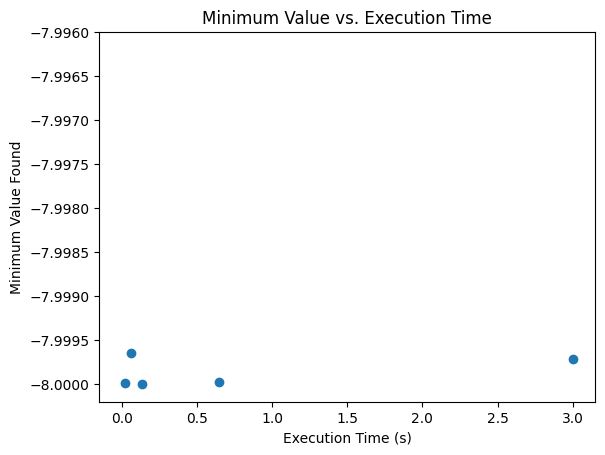

In [ ]:
min_lst = []
time_lst = []
for i in np.logspace(0, -2, 10):
  ns_time_start = time.time()
  gs_min, gs_point = global_search(f, bounds, mini_point_unit=i)
  ns_time_end = time.time() - ns_time_start
  print(f"Global Search Result: Minimum Value = {gs_min} at Point = {gs_point}")
  print(f"Time Taken: {ns_time_end:.4f} seconds\n")
  min_lst.append(gs_min)
  time_lst.append(ns_time_end)


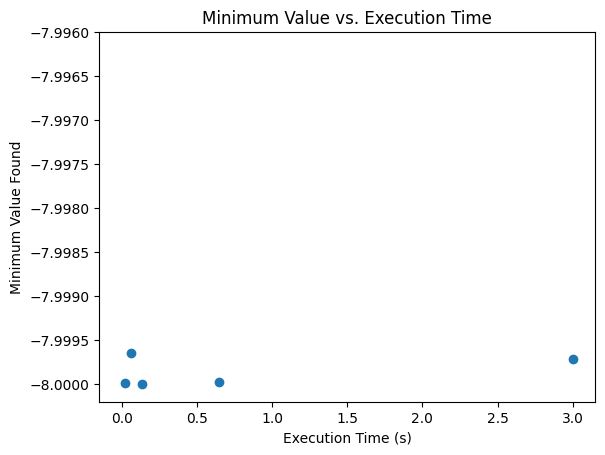

In [ ]:
plt.scatter(time_lst, min_lst)
plt.ylim(-8.0002, -7.996)  # Corrected: use plt.ylim instead of plt.set_ylim
plt.xlabel('Execution Time (s)')
plt.ylabel('Minimum Value Found')
plt.title('Minimum Value vs. Execution Time')
plt.savefig("minimum_vs_time_plot.png", format="png", dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
starting_points_sgd = [
    np.array([1/6**0.5, 1/6**0.5]),
    np.array([1/6**0.5, -1/6**0.5]),
    np.array([-1/6**0.5, 1/6**0.5]),
    np.array([-1/6**0.5, -1/6**0.5])
]

end_points_sgd = [[3,3],
                  [3,-3],
                  [-3,3],
                  [-3,-3]]

minima_sgd = []

def compute_minimum_sgd(start, end):
    x_min_sgd, f_min_sgd, processed_points = sgd_with_bound(f, grad_f, start, end, learning_rate=0.05, iterations=1000, tol=1e-5)
    return (x_min_sgd, f_min_sgd,processed_points)

sgd_seq_time = []
for _ in range(100):
  sgd_start_time = time.time()
  for i in range(4):
      start = starting_points_sgd[i]
      end = end_points_sgd[i]
      x_min_sgd, f_min_sgd,processed_points = compute_minimum_sgd(start,end)
      minima_sgd.append( (x_min_sgd, f_min_sgd,processed_points) )
  sgd_end_time = time.time() - sgd_start_time
  sgd_seq_time.append(sgd_end_time)

In [ ]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor()
sgd_para_time = []

for _ in range(100):
  sgd_start_time_para = time.time()
  results = list(executor.map(compute_minimum_sgd, starting_points_sgd, end_points_sgd))
  sgd_end_time_para = time.time() - sgd_start_time_para

  sgd_para_time.append(sgd_end_time_para)



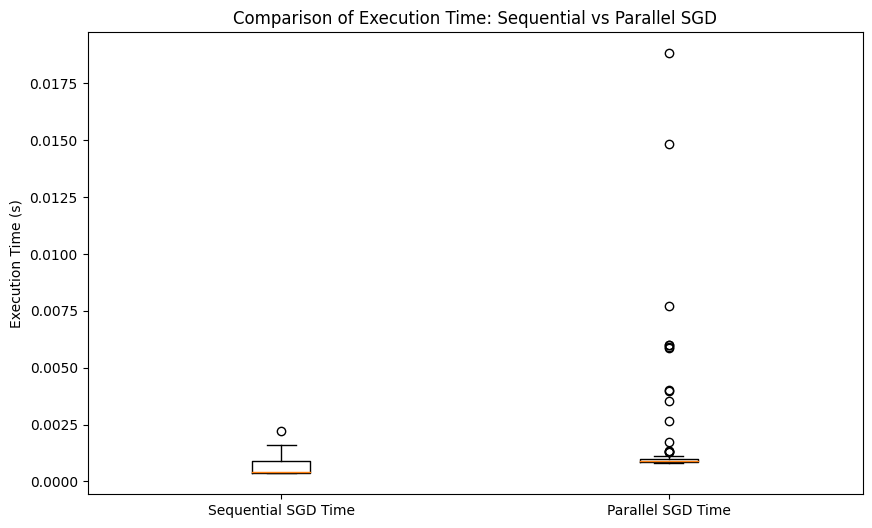

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([sgd_seq_time, sgd_para_time], labels=["Sequential SGD Time", "Parallel SGD Time"])
plt.ylabel("Execution Time (s)")
plt.title("Comparison of Execution Time: Sequential vs Parallel SGD")
plt.show()

In [ ]:
sgd_end_time

0.007681608200073242

In [ ]:
sgd_end_time_para

0.0044133663177490234

In [ ]:
def de_search_para(f, bounds,maxiters = 1000,popsize=15):
    """Perform Differential Evolution to find a global minimum."""
    result = differential_evolution(f, bounds,maxiter = maxiters,popsize=popsize)
    return result.x, result.fun


In [ ]:
reduced_bond = ([-1/6**0.5,1/6**0.5],[-1/6**0.5,1/6**0.5])
full_bound = ([-3,3],[-3,3])
full_bound_lst = []
reduced_bound_lst = []
for _ in range(100):
  de_start_time = time.time()
  de_result = de_search(f, full_bound)
  de_end_time = time.time() - de_start_time
  full_bound_lst.append(de_end_time)

  de_start_time_para = time.time()
  de_result = de_search_para(f, reduced_bond,maxiters = 10,popsize= 5)
  de_end_time_para = time.time() - de_start_time_para
  reduced_bound_lst.append(de_end_time_para)

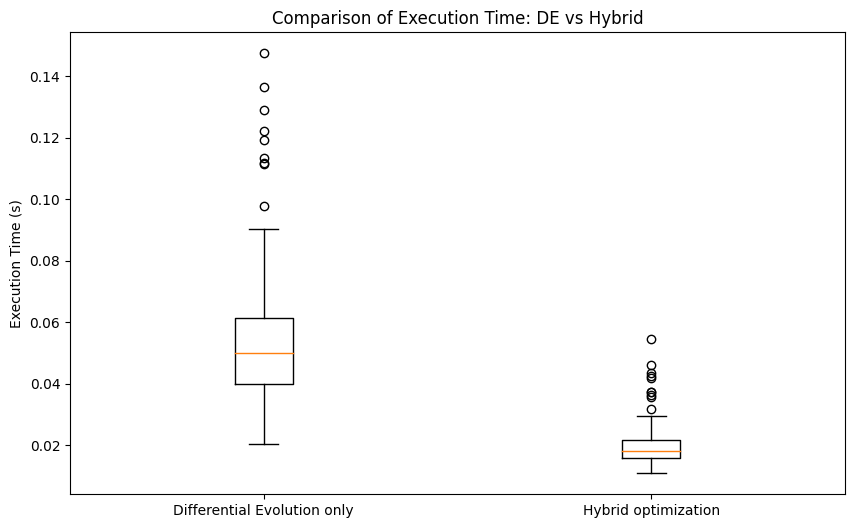

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([full_bound_lst, np.array(reduced_bound_lst)+np.array(sgd_para_time)], labels=["Differential Evolution only", "Hybrid optimization"])
plt.ylabel("Execution Time (s)")
plt.title("Comparison of Execution Time: DE vs Hybrid")
plt.show()

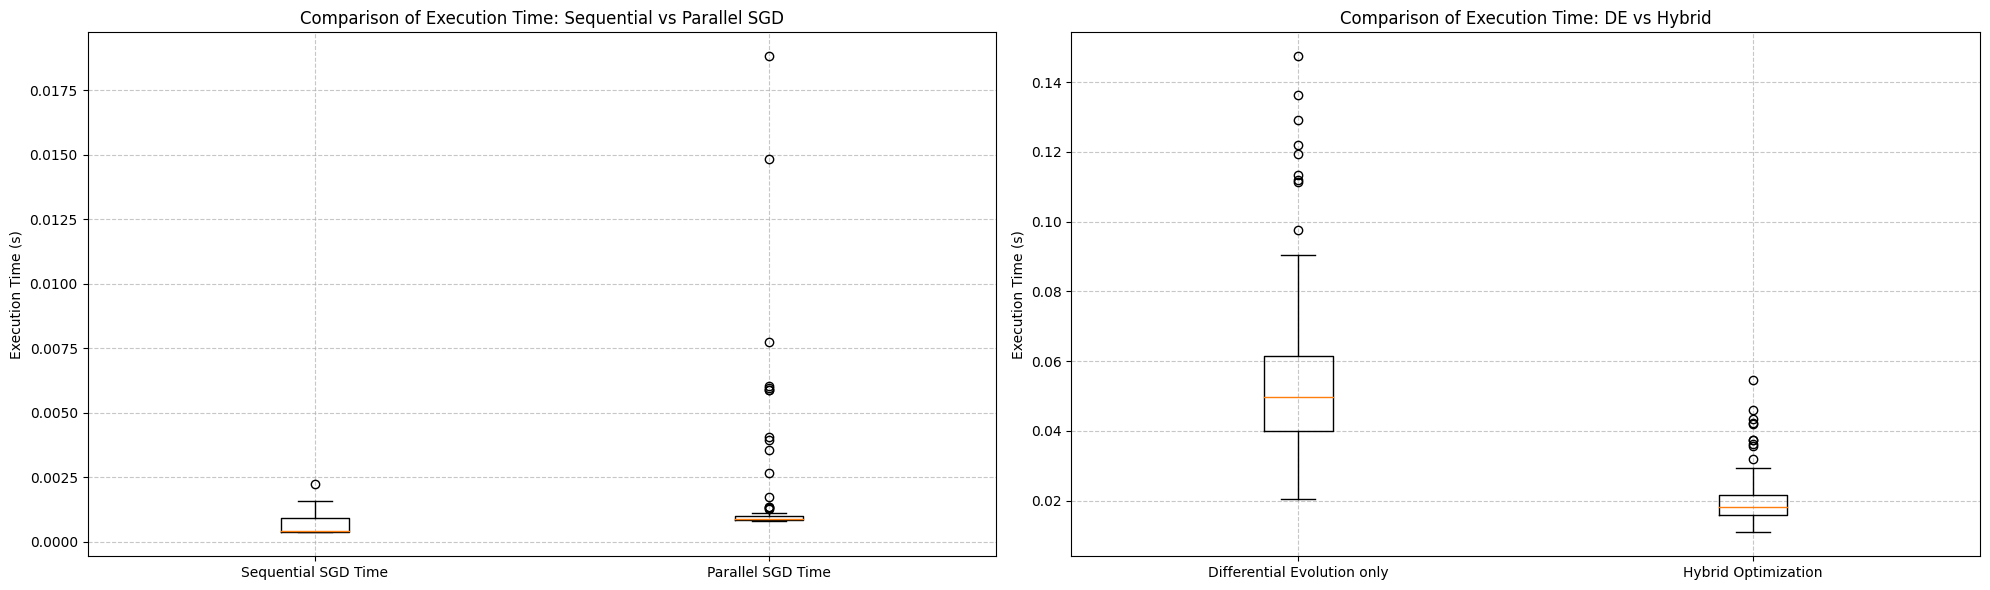

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))  # Adjust figsize as needed

# First Boxplot: Sequential vs Parallel SGD Time
axes[0].boxplot([sgd_seq_time, sgd_para_time], labels=["Sequential SGD Time", "Parallel SGD Time"])
axes[0].set_ylabel("Execution Time (s)")
axes[0].set_title("Comparison of Execution Time: Sequential vs Parallel SGD")
axes[0].grid(True, linestyle='--', alpha=0.7)  # Optional: Add grid for better readability

# Second Boxplot: Differential Evolution vs Hybrid Optimization
reduced_bound_plus_sgd = np.array(reduced_bound_lst) + np.array(sgd_para_time)

axes[1].boxplot([full_bound_lst, reduced_bound_plus_sgd], labels=["Differential Evolution only", "Hybrid Optimization"])
axes[1].set_ylabel("Execution Time (s)")
axes[1].set_title("Comparison of Execution Time: DE vs Hybrid")
axes[1].grid(True, linestyle='--', alpha=0.7)  # Optional: Add grid for better readability

# Adjust layout to prevent overlapping
plt.tight_layout()

# Optionally, save the figure to a file
plt.savefig("combined_boxplots.png", dpi=300)  # You can change the filename and format as needed

# Display the figure
plt.show()

In [ ]:
de_end_time_para

0.10043907165527344

In [ ]:
de_end_time_para

0.03690505027770996

In [ ]:
import sympy as sp

# Define symbols
x, y = sp.symbols('x y')

# Define the function's second derivatives
f_xx = 12 * x**2 - 2
f_yy = 12 * y**2 - 2

# Define convexity conditions
condition1 = f_xx >= 0
condition2 = f_yy >= 0

# Combine conditions using logical AND
combined_condition = sp.And(condition1, condition2)

time_step1 = time.time()
# Solve for x
solution_x = sp.solveset(12 * x**2 - 2 >= 0, x, domain=sp.S.Reals)

# Solve for y
solution_y = sp.solveset(12 * y**2 - 2 >= 0, y, domain=sp.S.Reals)
end_time_step1 = time.time() - time_step1

In [ ]:
end_time_step1

0.1322948932647705

In [ ]:
import platform

print(platform.processor())


x86_64


In [ ]:
import os

# Logical cores (includes hyper-threading)
logical_cores = os.cpu_count()

print(f"Logical cores: {logical_cores}")


Logical cores: 2
